### `DL Course, Dr. Fatemizadeh`
#### Homework 1
*`Full Name:`* Ali Soltani

*`SID:`* 403203449

## Introduction

This  exercises is more concerned with how the learning algorithms behave than with the nuts and bolts of implementation. If you are especially enthusiastic there are [Further exploration]() tasks on implementing support vector machines, but otherwise we will just use a standard implementation from `scikit-learn`. Instead, you are invited to generate data that will probe the model behaviour.

Examples of the kinds of plots that will be produced by your finished code are shown below.

![example of completed plots](https://comp0088.github.io/assets/colab/week_4_small.jpg)


## Setting Up

As usual, this notebook makes use of the NumPy library for numerical computing and the Matplotlib library for plotting, so we need to import them. And as mentioned above, we will use the [scikit-learn](https://pandas.pydata.org/docs/user_guide/index.html) library for our support vector machines.

In [1]:
import numpy as np
import numpy.random

from sklearn.svm import SVC

import matplotlib
import matplotlib.pyplot as plt

# this is probably the default, but just in case
%matplotlib inline

Upload all the contents of the HW1 folder to the main directory of the HW1 folder and then make sure the following cell runs correctly.

In [2]:
# at the moment this is all we care about
import HW1.utils as utils

The following function is an SVM-specific wrapper for `utils.plot_classification_map` that adds markers for the support vectors.

In [3]:
def plot_svm_map ( axes, svm, X, y, resolution, title ):
    """
    Utility to plot the classification map of an SVM
    highlighting the support vectors.
    """
    utils.plot_classification_map(axes, lambda z: svm.predict(z), X, y,
                                  resolution=resolution, title=title, legend_loc=None)
    axes.scatter(X[svm.support_,0], X[svm.support_,1],
                 facecolors='none', edgecolors='k', s=140, label='SV')
    axes.legend(loc='upper left')

Set up some items for later use.

In [4]:
# finally, set up some items for use in later code
shared_rng = numpy.random.default_rng()

LIMITS=(-5, 5)

# 30 points
# Task 1: Linear SVM

As discussed in the lectures, a linear SVM fits a decision boundary to maximise the **geometric margin** between that boundary and the worst case (i.e., nearest) training samples in each class. For a **hard margin** classifier, the classes must be **linearly separable**, whereas a **soft margin** SVM can allow misclassifications to an extent governed by a **cost** hyperparameter, $C$.

The geometric margin for a sample $(\mathbf{x}, y)$ is defined as:

\begin{equation}
M_g = \frac{y \, (\mathbf{x}\cdot\mathbf{w} + b)}{\|\mathbf{w}\|}
\end{equation}

where $\mathbf{w}$ and $b$ are the weights and bias defining the boundary, and $y$ uses the $\{-1, +1\}$ labelling convention (like Adaboost last week). The geometric margin for a whole dataset is the minimum of the geometric margins for all samples in the set.


## 1.1 Generate more realistic binary classification data

In the exercises for week 1 you were asked to generate linearly separable data, but the generating model was quite unrealistic — most data is unlikely to exhibit such a tight and consistent boundary, with neither errors nor any appreciable margin between the classes. Such data doesn't provide much intuition for SVM behaviour. Here you should come up with something more plausible.

Implement the body of the `generate_margined_binary_data` function in the cell below to provide a more realistic source of linearly separable data for which there actually is some separation between the classes.

You are free to devise any generating model you like as long as it produces some non-negligible margin between the classes. If you have the time and inclination, it might be worth trying out more than one formulation.

Note that the returned label vector should continue to use the same $\{0, 1\}$ labelling convention as in previous weeks.

In [5]:
def generate_margined_binary_data ( num_samples, count, limits, rng ):
    """
    Draw random samples from a linearly-separable binary model
    with some non-negligible margin between classes. (The exact
    form of the model is up to you.)

    # Arguments
        num_samples: number of samples to generate
            (ie, the number of rows in the returned X
            and the length of the returned y)
        count: the number of feature dimensions
        limits: a tuple (low, high) specifying the value
            range of all the features x_i
        rng: an instance of numpy.random.Generator
            from which to draw random numbers

    # Returns
        X: a matrix of sample vectors, where
            the samples are the rows and the
            features are the columns
            ie, its size should be:
              num_samples x count
        y: a vector of num_samples binary labels
    """
    # TODO: implement this
    low, high = limits

    # random normal vector
    w = rng.normal(size=(count,))
    w_norm = np.linalg.norm(w)
    if w_norm == 0:
        w[0] = 1.0
        w_norm = 1.0
    w_unit = w / w_norm

    # bias
    center = np.full((count,), 0.5 * (low + high))
    b = -np.dot(w_unit, center) + rng.normal(scale=0.05 * (high - low))

    # margin
    margin = 0.08 * (high - low) * np.sqrt(count)

    X = np.empty((num_samples, count), dtype=float)
    y = np.empty((num_samples,), dtype=int)

    for i in range(num_samples):
        x = rng.uniform(low, high, size=(count,))
        signed_dist = np.dot(w_unit, x) + b
        if abs(signed_dist) < margin:

            needed = (margin - abs(signed_dist)) + rng.uniform(1e-6, 0.02 * margin)
            sign = np.sign(signed_dist) if signed_dist != 0 else (1 if rng.random() < 0.5 else -1)
            x = x + sign * needed * w_unit

        X[i] = x
        y[i] = 1 if (np.dot(w_unit, x) + b) > 0 else 0

    return X, y

## 1.2 Calculate the geometric margin of a linear decision boundary

Implement the `geometric_margin` function in the cell below.

Note that the supplied label vector `y` will use the $\{0, 1\}$ labelling convention, not $\{-1, +1\}$. You will need to account for this in your calculations.

In [6]:
def geometric_margin ( X, y, weights, bias ):
    """
    Calculate the geometric margin for a given
    dataset and linear decision boundary. May be
    negative if any of the samples are
    misclassified.

    # Arguments
        X: an array of sample data, where rows are samples
           and columns are features.
        y: vector of ground truth labels for the samples,
           must be same length as number of rows in X
        weights: a vector of weights defining the direction
           of the decision boundary, must be the same
           length as the number of features
        bias: scalar intercept value specifying the position
           of the boundary

    # Returns:
        g: the geometric margin -- ie, the minimum distance
           of any of the samples on the correct side of the
           boundary (or the negative greatest distance on the
           wrong side)
    """
    assert(X.shape[0] == len(y))
    assert(X.shape[1] == len(weights))

    # TODO: implement this
    w = np.asarray(weights, dtype=float)
    X = np.asarray(X, dtype=float)
    y = np.asarray(y)

    w_norm = np.linalg.norm(w)

    # convert labels
    y_signed = 2 * y - 1

    # decision values
    decision_values = X.dot(w) + float(bias)

    # margins
    margins = (y_signed * decision_values) / w_norm

    return float(np.min(margins))

## → Run Task 1

Execute the code cell below to generate data, fit linear and RBF support vector machines to it, plot the results and estimate the geometric margin.

As in last week's lab, feel free to try out different values of `NUM_SAMPLES` and `RESOLUTION`, and also play with the cost parameter `COST` and the kernel bandwidth `GAMMA`.

Linear SVM geometric margin: 1.132


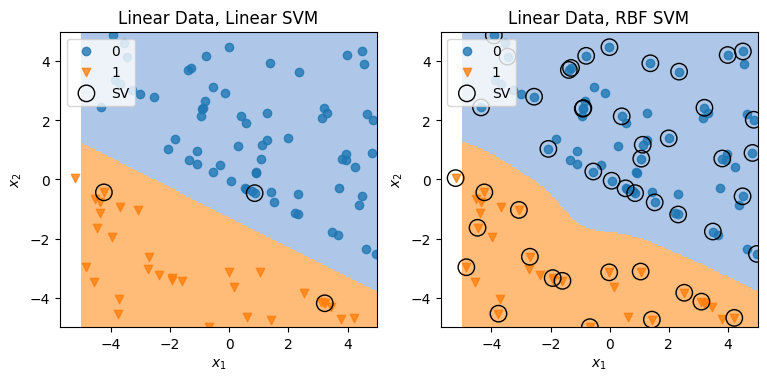

In [7]:
NUM_SAMPLES = 100
RESOLUTION = 200
COST = 1
GAMMA = 0.5

fig = plt.figure(figsize=(9, 5))
axs = fig.subplots(ncols=2)

# generate some data
X_lin, y_lin = generate_margined_binary_data ( NUM_SAMPLES, 2, LIMITS, shared_rng )

if X_lin is None:
  print('generate_margined_binary_data not implemented')
  utils.plot_unimplemented(axs[0], title='Linear Data, Linear SVM')
  utils.plot_unimplemented(axs[1], title='Linear Data, RBF SVM')
else:
  svm_lin = SVC(kernel='linear', C=COST)
  svm_lin.fit(X_lin, y_lin)

  plot_svm_map ( axs[0], svm_lin, X_lin, y_lin, RESOLUTION, title='Linear Data, Linear SVM' )

  svm_rbf = SVC(kernel='rbf', C=COST, gamma=GAMMA)
  svm_rbf.fit(X_lin, y_lin)

  plot_svm_map ( axs[1], svm_rbf, X_lin, y_lin, RESOLUTION, title='Linear Data, RBF SVM' )

  # calculate the geometric margin of the linear SVM
  marg_svm = geometric_margin(X_lin, y_lin, svm_lin.coef_[0,:], svm_lin.intercept_[0])

  if marg_svm is None:
    print('geometric_margin not implemented')
  else:
    print(f'Linear SVM geometric margin: {marg_svm:.3f}')

# 30 points
# Task 2: Perceptrons

The perceptron is a simple single-layer linear model for  binary classification. Its decision function is exactly the linear model boundary decision function described in Task 2 of Lab 1:

\begin{equation}
\hat{y} = \begin{cases}
	1 & \text{if $\mathbf{w}\cdot\mathbf{x} \ge 0$}\\
	0 & \text{otherwise}
     \end{cases}
\end{equation}

The model is trained iteratively, one training sample at a time, updating the weights at each step as:

\begin{equation}
\mathbf{w} \gets \mathbf{w} + \alpha (y - \hat{y}) \mathbf{x}
\end{equation}

where $\alpha$ is the learning rate. Training continues until there are no errors (and hence no updates) for the whole training set. Noting that $\nabla_{\mathbf{w}}(\mathbf{w \cdot x}) = \mathbf{x}$ and $(y - \hat{y})$ is the direction of any error, we can see that this update rule is effectively stochastic gradient descent on the **margin** of misclassified samples.

The perceptron is guaranteed to converge for linearly separable data, though time to converge depends on the margin. The boundary may be non-optimal and depends on the order in which samples are presented. It is guaranteed *never* to converge when the data are not linearly separable — there will always be an error somewhere.


## 2.1 Learn a decision boundary with the perceptron algorithm

Implement the `perceptron_train` function in the code cell below.

As mentioned in the docstring, you should return the final weights vector even if the algorithm fails to converge.

Input labels will be $\{0, 1\}$.


In [8]:
def perceptron_train ( X, y, alpha=1, max_epochs=50, include_bias=True ):
    """
    Learn a linear decision boundary using the
    perceptron algorithm.

    # Arguments
        X: an array of sample data, where rows are samples
            and columns are features.
        y: vector of ground truth labels for the samples,
            must be same length as number of rows in X
        alpha: learning rate, ie how much to adjust the
            boundary for each misclassified sample
        max_epochs: maximum number of passes over the
            training set before admitting defeat
        include_bias: whether to automatically add a
            a constant bias feature x0

    # Returns:
        weights: vector of feature weights defining the
            decision boundary, either same length as number of
            columns in X or 1 greater if include_bias is True.
            (note that a weights vector will be returned even if
            the algorithm fails to converge)
    """
    assert(X.shape[0] == len(y))

    # TODO: implement this

    if include_bias:
        X = np.hstack([np.ones((X.shape[0], 1)), X])

    # initialise weights
    weights = np.zeros(X.shape[1])

    # training loop
    for epoch in range(max_epochs):
        errors = 0
        for i in range(X.shape[0]):
            x = X[i]
            pred = 1 if np.dot(weights, x) >= 0 else 0
            if pred != y[i]:
                weights += alpha * (y[i] - pred) * x
                errors += 1
        if errors == 0:
            break

    return weights

## 2.2 Predict binary labels from the learned boundary

Implement the body of the `perceptron_predict` function in the cell below.

The return predictions should be in $\{0, 1\}$.

In [9]:
def perceptron_predict ( test_X, weights ):
    """
    Predict binary labels for a dataset using a specified
    decision boundary. (This is intended for us with a boundary
    learned with the perceptron algorithm, but any suitable
    weights vector can be used.)

    # Arguments
        test_X: an array of sample data, where rows are samples
            and columns are features.
        weights: vector of feature weights defining the
            decision boundary, either same length as number of
            columns in X or 1 greater -- in the latter case it
            is assumed to contain a bias term, and test_X will
            have a constant term x0=1 prepended

    # Returns
        pred_y: a vector of predicted binary labels
            corresponding to the samples in test_X

    """
    assert(test_X.shape[1] in (len(weights),len(weights)-1))

    # TODO: implement this
    if test_X.shape[1] == len(weights) - 1:
        test_X = np.hstack([np.ones((test_X.shape[0], 1)), test_X])

    preds = []
    for i in range(test_X.shape[0]):
        x = test_X[i]
        pred = 1 if np.dot(weights, x) >= 0 else 0
        preds.append(pred)

    return np.array(preds)

## → Run Task 2

Execute the code cell below to use your functions above to train and test a linear classifier with the perceptron algorithm. Note that this code expects to use the same linearly-separable data generated in Task 1, and will attempt to compare the margins of the boundaries discovered by the perceptron and linear SVM.


Perceptron geometric margin: 0.346
SVM margin greater by: 0.786


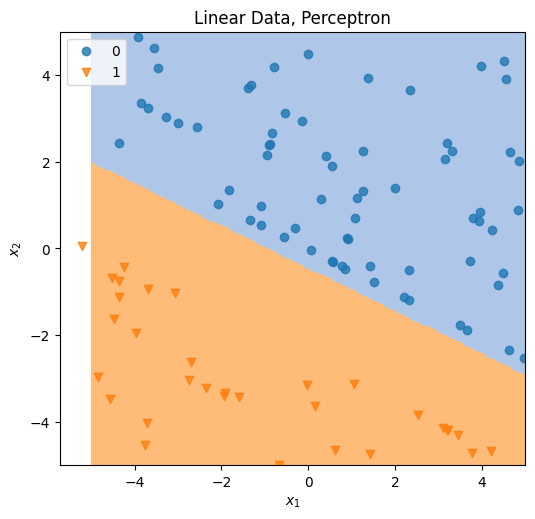

In [10]:
fig = plt.figure(figsize=(6, 6))
ax = fig.subplots()

pw = perceptron_train(X_lin, y_lin)
if pw is None:
    print('perceptron not implemented')
    utils.plot_unimplemented(ax, title='Linear Data, Perceptron')
else:
    utils.plot_classification_map(ax, lambda z: perceptron_predict(z, pw), X_lin, y_lin, resolution=RESOLUTION, title='Linear Data, Perceptron')

    marg_ptron = geometric_margin(X_lin, y_lin, pw[1:], pw[0])

    if marg_svm is None:
        print('geometric_margin not implemented')
    else:
        print(f'Perceptron geometric margin: {marg_ptron:.3f}')
        print(f'SVM margin greater by: {marg_svm - marg_ptron:.3f}')


# 30 points
# Task 3: Non-Linear Data

The behaviour of linear classifiers on linearly-separable data is relatively uncontentious. It’s in the face of data that is not linearly separable that things become interesting.

Notoriously, the perceptron algorithm will fail outright in such cases. A (soft margin) linear SVM will find the best boundary it can, but can still only draw a linear boundary so must concede errors somewhere. But by implicitly expanding into a much higher dimensional basis, a kernel SVM can fit nearly any kind of data.

## 3.1 Generate non-linear binary data

Implement the `generate_binary_nonlinear_2d` function in the code cell below.

You are free to devise any generating model you like, and it is definitely worth trying out more than one candidate.

As in the previous tasks, the returned label vector should continue to use the $\{0, 1\}$ labelling convention.


In [11]:
def generate_binary_nonlinear_2d ( num_samples, limits, rng ):
    """
    Draw random samples from a binary model that is *not*
    linearly separable in its 2D feature space. (The exact
    form of the model is up to you.)

    # Arguments
        num_samples: number of samples to generate
            (ie, the number of rows in the returned X
            and the length of the returned y)
        limits: a tuple (low, high) specifying the value
            range of all the features x_i
        rng: an instance of numpy.random.Generator
            from which to draw random numbers

    # Returns
        X: a matrix of sample vectors, where
            the samples are the rows and the
            features are the columns
            ie, its size should be:
              num_samples x count
        y: a vector of num_samples binary labels
    """
    # TODO: implement this
    low, high = limits
    center = 0.5 * (low + high)
    radius_scale = 0.35 * (high - low)

    X = np.zeros((num_samples, 2), dtype=float)
    y = np.zeros((num_samples,), dtype=int)

    for i in range(num_samples):
        # choose class randomly
        label = rng.integers(0, 2)
        y[i] = int(label)

        theta = rng.uniform(0, 2 * np.pi)
        if label == 0:
            r = rng.normal(loc=0.7 * radius_scale, scale=0.07 * radius_scale)
        else:
            r = rng.normal(loc=1.3 * radius_scale, scale=0.09 * radius_scale)

        # convert metrics
        x = center + r * np.cos(theta) + rng.normal(scale=0.02 * (high - low))
        z = center + r * np.sin(theta) + rng.normal(scale=0.02 * (high - low))

        X[i, 0] = x
        X[i, 1] = z

    return X, y

## → Run Task 3

Execute the code cell below to use your function above to generate some non-linear data, train a linear classifier on it with the perceptron algorithm and also a non-linear SVM, and plot the results of each. Do they behave as you'd expect?

Once again, feel free to adjust `NUM_SAMPLES` and `RESOLUTION`, bearing in mind that high values may slow things down. You should also play around with the SVM parameters `COST` and `GAMMA` to get a feel for how these affect the learned boundary.


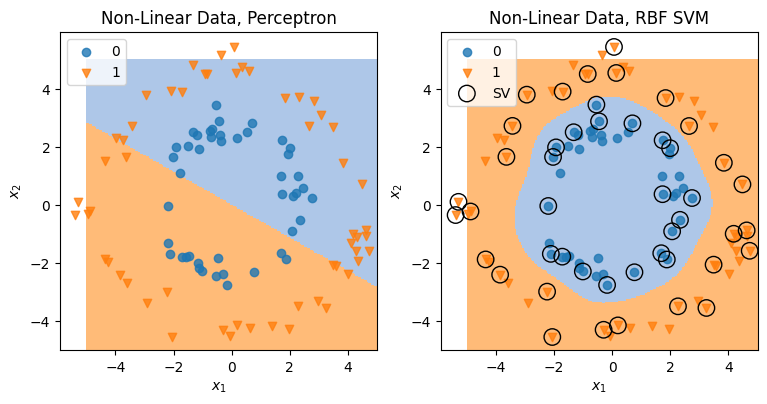

In [12]:
NUM_SAMPLES = 100
RESOLUTION = 200
COST = 1
GAMMA = 0.5

fig = plt.figure(figsize=(9, 5))
axs = fig.subplots(ncols=2)

# generate some data
X_non, y_non = generate_binary_nonlinear_2d ( NUM_SAMPLES, LIMITS, shared_rng )

if X_non is None:
  print('generate_binary_nonlinear_2d not implemented')
  utils.plot_unimplemented(axs[0], title='Non-Linear Data, Perceptron')
  utils.plot_unimplemented(axs[1], title='Non-Linear Data, RBF SVM')
else:
  pw = perceptron_train(X_non, y_non)
  if pw is None:
    print('perceptron not implemented')
    utils.plot_unimplemented(axs[0], title='Non-Linear Data, Perceptron')
  else:
    utils.plot_classification_map(axs[0], lambda z: perceptron_predict(z, pw), X_non, y_non, resolution=RESOLUTION, title=f'Non-Linear Data, Perceptron')

  svm_rbf = SVC(kernel='rbf', C=COST, gamma=GAMMA)
  svm_rbf.fit(X_non, y_non)

  plot_svm_map ( axs[1], svm_rbf, X_non, y_non, RESOLUTION, title='Non-Linear Data, RBF SVM')


# 30 points
# Task 4: Kernel Functions

The SVM implementation in `scikit-learn` (specifically [`sklearn.svm.SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)) has in-built (and optimised) support for the commonly-used **radial basis** and **polynomial** kernels, but also allows for arbitrary kernels to be used by supplying a function that computes the Gram matrix.

NB: generating and using a custom kernel matrix can be very slow for large datasets, so I'd recommend keeping `NUM_SAMPLES` small for this task, especially while hacking around with it.

## 4.1 Implement a custom kernel function

Provide an implementation body for the `custom_kernel` function defined in the code cell below.

Note that this function computes the kernel space inner products between two sets of data vectors. In the context of *training*, the two sets will be the same — `X1 == X2`. The resulting matrix will be square and must be symmetric and positive semi-definite. In the context of *evaluation*, the two will be different and those conditions will not hold.

You can define any kernel function you like here, as long as it is valid. Can you come up with a kernel that interacts interestingly with the data model you've implemented in Task 3.1? (Spoiler alert: you may well not be able to, arbitrary kernel functions are often not very interesting.)

The `gamma` parameter here is passed in from the `GAMMA` configuration variable, just as it was for the RBF kernel above. You are not required to do anything with it, but the option is there in case you want to experiment with some parameterisable kernel function.




In [13]:
def custom_kernel ( X1, X2, gamma=0.5 ):
    """
    Custom kernel function for use with a support
    vector classifier.

    # Arguments
        X1: first array of sample data for comparison,
            with samples as rows and features as
            columns (size N1 x M)
        X2: second array of sample data for comparison,
            with samples as rows and features as
            columns (size N2 x M; may be the same
            as X1)
        gamma: a scaling hyperparameter for the similarity
            function

    # Returns
        K: the Gram matrix for the kernel, giving the
           kernel space inner products for each pairing of
           a vector in X1 with one in X2 (size N1 x N2)
    """
    assert(X1.shape[1] == X2.shape[1])

    # TODO: implement this
    K_linear = np.dot(X1, X2.T)

    K_poly = (np.dot(X1, X2.T) + 1) ** 2

    sq_dists = np.sum(X1**2, axis=1)[:, np.newaxis] + np.sum(X2**2, axis=1)[np.newaxis, :] - 2 * np.dot(X1, X2.T)
    K_rbf = np.exp(-gamma * sq_dists)

    K = K_linear + 0.5 * K_poly + 0.5 * K_rbf

    return K

## → Run Task 4

Execute the code cell below to train an SVM using your custom kernel on data from your non-linear generator and plot the results. Does your kernel do what you think it should? Does it seem potentially useful?

Once again, feel free to tweak the parameters `NUM_SAMPLES` and `RESOLUTION`, but be aware that SVMs with custom kernels can become **very** slow as the data size increases.


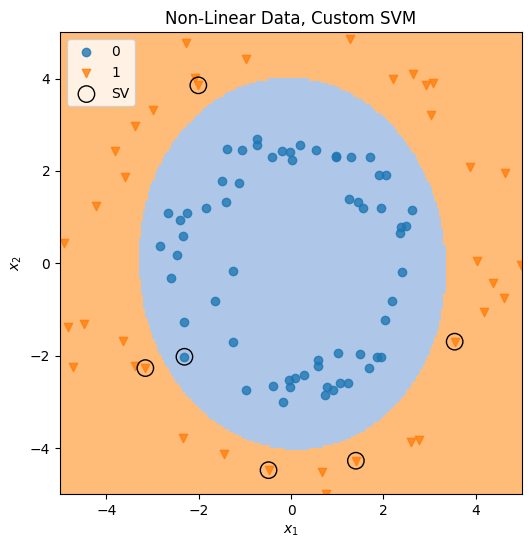

In [14]:
NUM_SAMPLES = 100
RESOLUTION = 200
COST = 1
GAMMA = 0.5

fig = plt.figure(figsize=(6, 6))
ax = fig.subplots()

# generate some data
X_non, y_non = generate_binary_nonlinear_2d ( NUM_SAMPLES, LIMITS, shared_rng )

if X_non is None:
  print('generate_binary_nonlinear_2d not implemented')
  utils.plot_unimplemented(ax, title='Non-Linear Data, Custom SVM')
else:
  # check custom kernel at least superficially works
  # before trying to train an SVM with it
  zz = np.zeros((1,1))
  if custom_kernel(zz,zz) is None:
    print('custom kernel not implemented')
    utils.plot_unimplemented(ax, title='Non-Linear Data, Custom SVM')
  else:
    def kernel ( x, y ):
      return custom_kernel(x, y, GAMMA)

    svm_cust = SVC(kernel=kernel, C=COST)
    svm_cust.fit(X_non, y_non)

    plot_svm_map ( ax, svm_cust, X_non, y_non, RESOLUTION, title='Non-Linear Data, Custom SVM')

# 30 points
# Further exploration


## Implement a linear SVM using hinge loss optimisation

 (linear) SVM fitting can be implemented via gradient descent optimisation of a regularised **hinge loss**:

\begin{equation}
\mathbf{w}^{\star}, b^{\star} = \text{argmin}_{\mathbf{w},b} \; \frac{1}{k} \sum_i^k \max\big(0, 1 - y_i (\mathbf{x}_i \cdot \mathbf{w} + b)\big) + \frac{\lambda}{2} \|\mathbf{w}\|^2
\end{equation}

where we've chosen to average the hinge loss over the mini-batch size $k$. The hinge loss is not differentiable, but we can define a subgradient. If $L$ is the hinge loss for an individual sample:

\begin{equation}
L(\mathbf{x},y) = \max\big(0, 1-y(\mathbf{x \cdot w} + b)\big)
\end{equation}

then

\begin{align}
\nabla_{\mathbf{w}} L &= -y \, \mathbf{x} \cdot \mathbb{1}\big(y (\mathbf{x} \cdot \mathbf{w} + b) < 1\big) \\
\frac{\partial L}{\partial b} &= -y \cdot \mathbb{1}\big(y (\mathbf{x} \cdot \mathbf{w} + b) < 1\big)
\end{align}

and the mini-batch parameter updates are:

\begin{align}
\mathbf{w} &\gets \mathbf{w} - \alpha \bigg[ \lambda \mathbf{w} - \frac{1}{k} \sum_i y_i \mathbf{x}_i \cdot \mathbb{1}\Big(y (\mathbf{x \cdot w} + b) < 1\Big) \bigg] \\
b &\gets b - \alpha \bigg[ -\frac{1}{k} \sum_i y_i \cdot \mathbb{1}\Big(y_i (\mathbf{x}_i \cdot \mathbf{w} + b) < 1\Big) \bigg]
\end{align}

where $\alpha$ is the learning rate.

Try implementing this and seeing how it behaves. If you consider the stochastic gradient descent case (i.e., $k=1$), how does this relate to the perceptron algorithm?


In [15]:
def hinge_loss_grad(X, y, w, b, lam):
    """
    Compute gradients for hinge loss with L2 regularization.
    """
    k = X.shape[0]

    # Compute decision values
    decision = y * (X @ w + b)  # shape: (k,)

    # Indicator for hinge loss active
    mask = (decision < 1).astype(float)

    # Compute gradients
    dw = lam * w - (1/k) * np.sum((mask * y)[:, np.newaxis] * X, axis=0)
    db = - (1/k) * np.sum(mask * y)

    return dw, db

In [16]:
def train_linear_svm(X, y, lam=0.01, alpha=0.1, epochs=1000, batch_size=None):
    """
    Train linear SVM using mini-batch gradient descent on hinge loss.
    """
    N, d = X.shape
    w = np.zeros(d)
    b = 0.0

    if batch_size is None:
        batch_size = N  # full batch by default

    for epoch in range(epochs):
        # Shuffle data
        perm = np.random.permutation(N)
        X_shuff = X[perm]
        y_shuff = y[perm]

        for start in range(0, N, batch_size):
            end = start + batch_size
            X_batch = X_shuff[start:end]
            y_batch = y_shuff[start:end]

            dw, db = hinge_loss_grad(X_batch, y_batch, w, b, lam)

            # Update parameters
            w -= alpha * dw
            b -= alpha * db

    return w, b

In [17]:
def predict_linear_svm(X, w, b):
    """
    Predict labels using trained linear SVM.
    """
    scores = X @ w + b
    return np.where(scores >= 0, 1, -1)

### Testing

In [18]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [19]:
X, y = make_classification(
    n_samples=200,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    flip_y=0.1,
    class_sep=1.5,
    random_state=42
)

# Convert labels to +1/-1
y = 2*y - 1

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

w, b = train_linear_svm(
    X_train,
    y_train,
    lam=0.01,
    alpha=0.1,
    epochs=1000,
    batch_size=10
)


y_pred_train = predict_linear_svm(X_train, w, b)
y_pred_test = predict_linear_svm(X_test, w, b)


train_acc = np.mean(y_pred_train == y_train)
test_acc = np.mean(y_pred_test == y_test)

print(f"Learned weights: {w}")
print(f"Learned bias: {b:.4f}")
print(f"Training accuracy: {train_acc*100:.2f}%")
print(f"Test accuracy: {test_acc*100:.2f}%")

Learned weights: [-0.25771944  0.96166369]
Learned bias: 0.3400
Training accuracy: 88.57%
Test accuracy: 86.67%


## Implement a kernel-capable SVM using a QP solver

The standard NumPy/SciPy stack does not include a quadratic programming solver, so you'll need to install other packages to perform this task. I'd suggest using [cvxpy](https://www.cvxpy.org), though you could also try [cvxopt](https://cvxopt.org).

QP solvers require the problem to posed in very specific forms, which vary according to the implementation. Getting to grips with this can be a little involved, which is one reason why this task is not part of the main lab exercises. But sample code is easy to find — e.g., see [this example](https://www.cvxpy.org/examples/machine_learning/svm.html) for cvxpy, which implements a slightly different ($L_1$ regularised) SVM in QP form.


## Use an SVM to classify handwritten digits

One of the early SVM successes, which helped build the reputation of the method, was in recognition of handwritten digits. Such recognition remains a very common computer vision testbed task.

The standard dataset for digit recognition tasks is [MNIST](http://yann.lecun.com/exdb/mnist/), in which the individual digit samples are $28\times 28$ pixel greyscale images. MNIST data can be downloaded from the [OpenML](https://openml.org) repository using `scikit-learn`'s dataset functions:

```python
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
```

`scikit-learn` also provides a much smaller dataset of $8 \times 8$ pixel handwritten digit images which you may prefer to use for more tractable computation:

```python
from sklearn.datasets import load_digits
X, y = load_digits(return_X_y=True, as_frame=False)
```

For either dataset, you will need to split the data into disjoint **train, test and validation sets** and determine appropriate hyperparameters to use for training your SVM.

Note also that this is a **multiclass** problem, while SVMs are inherently binary classifiers, so an appropriate aggregation scheme is needed. However, the [`sklearn.svm.SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) class will take care of this for you, employing a **one-vs-one** decision strategy.


In [20]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [21]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

y = y.astype(int)

# Normalize pixel values
X = X / 255.0

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
)

svm_model = SVC(
    kernel='rbf',
    C=5.0,
    gamma=0.05,
    decision_function_shape='ovo'
)

In [22]:
svm_model.fit(X_train, y_train)

,C,5.0
,kernel,'rbf'
,degree,3
,gamma,0.05
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [23]:
y_val_pred = svm_model.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy: {val_acc*100:.2f}%")

y_test_pred = svm_model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy: {test_acc*100:.2f}%")

Validation accuracy: 98.10%
Test accuracy: 98.19%
